In this section we will apply ML techniques to our data, starting with Weapons.csv to predict UsefulnessScore for the wepons


In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

url_prefix = "https://raw.githubusercontent.com/HCanCaglar/DSA210_Fear_and_Hunger/main"



numeric_columns = ['ATK', 'AltWeaponsLowerOrEqual', 'WeaponNumber', 'NumEnemiesDrop',
                   'EnemyPopulationDrop', 'NumRNGSpots', 'NumGuaranteedSpots', 'UsefulnessScore']



In [82]:


# Load and transpose
weapons_df = pd.read_csv(f"{url_prefix}/Weapons.csv", sep=';', index_col=0)
weapons_df.columns = weapons_df.columns.str.strip()  # Clean up weapon names
weapons_df = weapons_df.T.reset_index().rename(columns={'index': 'Weapon'})

# Clean AcquisitionType: strip leading/trailing whitespace, drop NaNs
weapons_df['AcquisitionType'] = weapons_df['AcquisitionType'].fillna('').str.strip()

# Split, then strip each inner element too
acquisition_split = weapons_df['AcquisitionType'].apply(lambda x: [i.strip() for i in x.split(',')] if x else [])

# We apply multi-hot encoding for our ML to use
mlb = MultiLabelBinarizer()
acq_encoded = pd.DataFrame(
    mlb.fit_transform(acquisition_split),
    columns=mlb.classes_,
    index=weapons_df.index
)

# Combine the hot encoding to each weapon
combined_df = pd.concat([weapons_df[['Weapon']], acq_encoded], axis=1)


from tabulate import tabulate
print(tabulate(combined_df, headers='keys', tablefmt='grid', showindex=False))


+------------------------+-------------+-------------+-------+
| Weapon                 |   EnemyDrop |   Guarantee |   RNG |
+========================+=============+=============+=======+
| Short Sword            |           1 |           0 |     1 |
+------------------------+-------------+-------------+-------+
| Long Sword             |           1 |           0 |     1 |
+------------------------+-------------+-------------+-------+
| Iron spear             |           0 |           0 |     1 |
+------------------------+-------------+-------------+-------+
| Iron mace              |           0 |           0 |     1 |
+------------------------+-------------+-------------+-------+
| short bow              |           0 |           0 |     1 |
+------------------------+-------------+-------------+-------+
| scimitar               |           0 |           0 |     1 |
+------------------------+-------------+-------------+-------+
| dagger                 |           0 |           1 | 

Above is the table created by our Weapons.csv. it shows if any of the weapons have the respective acquisition method for our ML to use for predicting the Usefulness Score. we need to weperate them because each weapon can have multiple acquisiton methods which is crucial in calculating usefulness score


 Linear Regression
R²: 0.9973749286231963
RMSE: 0.4785029003633366


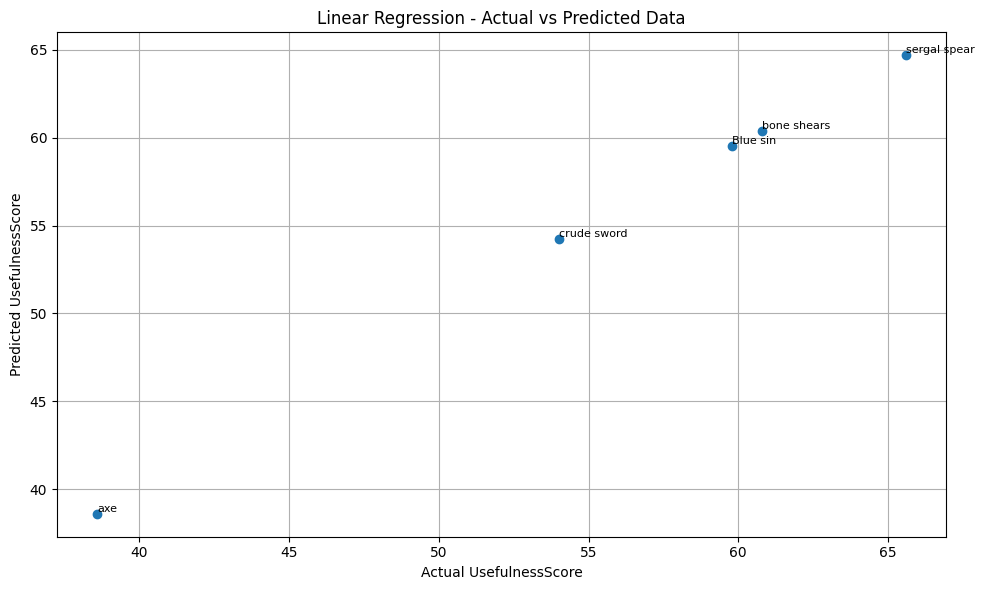


 K-Nearest Neighbours
R²: 0.2313497450196278
RMSE: 8.188010747428217


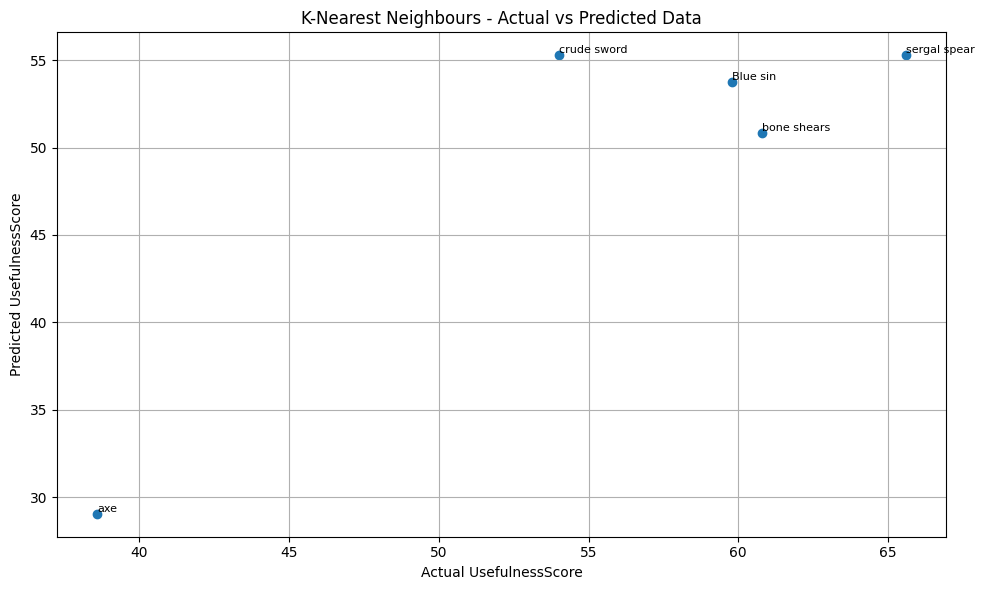

In [83]:
for col in numeric_columns:
    weapons_df[col] = weapons_df[col].astype(str).str.replace(',', '.').astype(float)


# Final dataset
X = pd.concat([weapons_df[numeric_columns[:-1]], acq_encoded], axis=1)  # Exclude UsefulnessScore
y = weapons_df['UsefulnessScore']



# Train-test and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=50 ) #,random_state=50 fixes the weapons we use to predict

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to use and find which one is the best
models = {
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbours": KNeighborsRegressor(),
}

# Train and evaluate the models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    print(f"\n {name}")
    print("R²:", r2_score(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

    weapon_names = weapons_df.loc[y_test.index, 'Weapon']

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds)

    for i in range(len(y_test)):
        plt.text(y_test.iloc[i], preds[i], weapon_names.iloc[i], fontsize=8, ha='left', va='bottom', rotation=0)

    plt.xlabel("Actual UsefulnessScore")
    plt.ylabel("Predicted UsefulnessScore")
    plt.title(f"{name} - Actual vs Predicted Data")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



For predicting our UsefulnessScore we used 2 different ML models to see which one is the best fit. we have used 80% as the actual data and 20% to be predicted. each run of the code creates new predictions for the newly chosen random 20% of weapons

R² is the goodnes of fit, if it is closer to 1 that means our ML model has predicted the UsefulnessScore better

RMSE is the root mean squared error. it is used to see the how far off is our prediction compared  to actual values of usefulness score. the smaller it is the better is ur prediction

then we graphed each model. from the graphs and the output we can see that Multiple Linear Regression has the highest R² and lowest RMSE. this is actually predicted because

 UsefulnessScore = AltWeaponsLowerOrEqual + NumEnemiesDrop + NumRNGSpots + NumGuaranteedSpots

and Usefulness score is affected by multiple variables and each of them affect the score independently. this is why the model predicted the score efficiently

on the other hand KNN doesnt directly calculate the usefulness score of the weapon but looks at closest 5 neighbours by default. but my dataset is very small and precise in data and most of the nearby weapon data are different from each other: high atk lower acquisiton methods or low attack but higher acquisition methods. therefore its R²  very low and RMSE is actually quite high and the neighbors we compare with are different from the predicted data

Therefore we can conlude that Multiple Linear Regression is the best model we can use to predict a weapon's data. which is also proven by the linearity of the graph of Linear Regression and non-precise prediction done by K-Nearest Neighbors

however by removing  ,random_state=50 from the code and  making the randomly chosen 20% to eb rechosen can imporve the KNN's R² but I havent encounted LR to ever have lower R² value and always having lower RMSE compared to KNN model.

Below we will choose a ML model for calculating DangerLever for a status effect. we dont need to use one hot encoding here because all the data here is numerical unlike acquisiton methods in Weapons.csv


In [72]:


# Load and transpose the .csv
url_prefix = "https://raw.githubusercontent.com/HCanCaglar/DSA210_Fear_and_Hunger/main"
status_df = pd.read_csv(f"{url_prefix}/StatusEffectsAndCures.csv", sep=';')

status_df.set_index('Name', inplace=True)
status_df = status_df.T.reset_index().rename(columns={'index': 'StatusEffect'})

# Convert numeric columns from strings with commas to float
numeric_columns = ['NumEnemiesToGet', 'NumCures', 'TotalCureCount', 'Curability', 'DangerLevel']
for col in numeric_columns:
    status_df[col] = status_df[col].astype(str).str.replace(',', '.').astype(float)





Linear Regression
R²: 0.999376187190463
RMSE: 0.1544134444638633


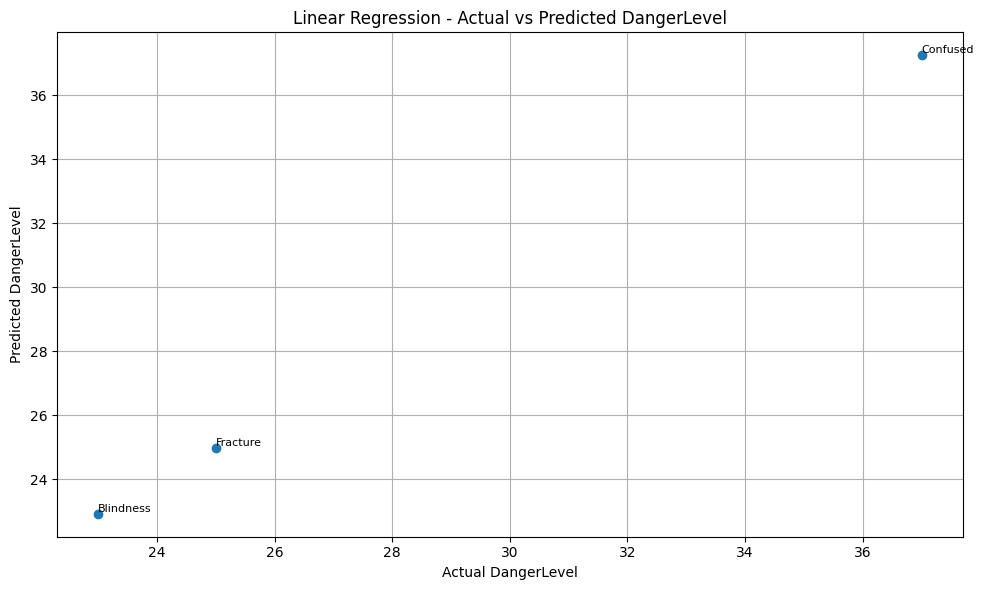


K-Nearest Neighbours
R²: -0.1190697674418606
RMSE: 6.540132516496385


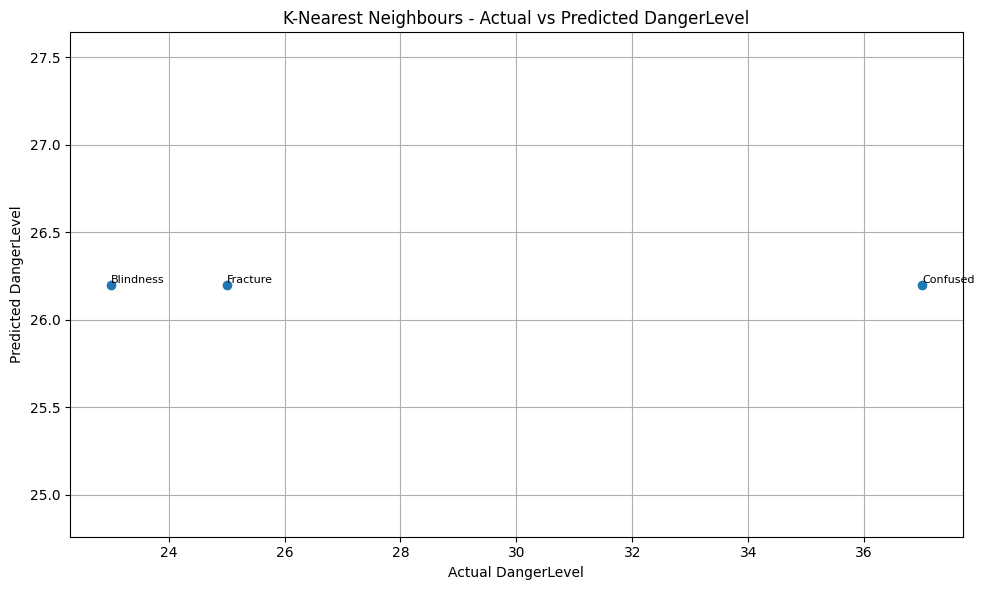

In [77]:
X = status_df[numeric_columns[:-1]]  # All except DangerLevel to calculate and compare
y = status_df['DangerLevel']

# Train-test and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50) #get rid of , random_state=50 to randomly choose a new set of status

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to use and find which one is the best
models = {
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbours": KNeighborsRegressor(),
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    print(f"\n{name}")
    print("R²:", r2_score(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

    effect_names = status_df.loc[y_test.index, 'StatusEffect']
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds)
    for i in range(len(y_test)):
        plt.text(y_test.iloc[i], preds[i], effect_names.iloc[i], fontsize=8, ha='left', va='bottom', rotation=0)

    plt.xlabel("Actual DangerLevel")
    plt.ylabel("Predicted DangerLevel")
    plt.title(f"{name} - Actual vs Predicted DangerLevel")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

For predicting our UsefulnessScore we used 2 different ML models to see which one is the best fit. we have used 80% as the actual data and 20% to be predicted. each run of the code creates new predictions for the newly chosen random 20% of weapons

DangerLevel is Calculated as: NumWaysToGet - CureAvailabilityScore + (Uncurable * 20)

then we graphed each model. from the graphs and the output, this time we mostly say that Multiple Linear Regression is beter than KNN. Because in our StatusEffectAndCures.csv file or the excel file, we can see that some of the status effects are very close to each other in terms of danger level and some others are way too far off. so when we use KNN to compare a status effect which is uncurable and has a lot of evenies that apply it with a neighbor that is curable with low number of enemies we can get negative R² values but if the randomly chosen data is looked at a similar status effect in KNN model we see R² very close to 1 just like MLR model. but MLR model always gets high R² and low RMSE so we can conclude that MLR is a better model.


By removing  ,random_state=50 from the code and  making the randomly chosen 20% to be re-chosen can imporve the KNN's R² or un-improve it greatly